# Query language models
Let's test different monolingual models for the task of filling in blanks for relationship targets.

We'll use the multilingual BERT model for consistency across languages. If this gives weird results for specific languages (e.g. poor accuracy only for Italian), we may pivot to using individual models for each language.

In [1]:
from transformers import BertTokenizer, BertModel, pipeline
cache_dir = 'data/'
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', cache_dir=cache_dir)
model_pipeline = pipeline('fill-mask', model='bert-base-multilingual-cased', tokenizer='bert-base-multilingual-cased', model_kwargs={'cache_dir' : cache_dir})

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

In [2]:
a = model_pipeline.tokenizer('el hombre se casó con su novio')
print(model_pipeline.tokenizer.convert_ids_to_tokens(a['input_ids']))

['[CLS]', 'el', 'hombre', 'se', 'casó', 'con', 'su', 'novi', '##o', '[SEP]']


In [3]:
import pandas as pd
# import torch
# def pred_mask_tokens(sent, tokenizer, model):
#     model_input = tokenizer(sent)
#     model_output = model(model_input)
#     logits = model_output.logits
#     token_map = 
test_sents = [
    'The man married his [MASK].', 
    'El hombre se casó con su [MASK].',
    "L'homme s'est marié avec son [MASK].",
    "L'homme s'est marié avec sa [MASK]."
]
test_targets = [
    ['wife', 'husband', 'girlfriend', 'boyfriend'],
    ['esposa', 'esposo', 'novia', 'novio'],
    ['épouse', 'époux', 'copain'],
    ['copine'],
]
for test_sent_i, test_targets_i in zip(test_sents, test_targets):
    test_sent_pred_i = model_pipeline(test_sent_i, targets=test_targets_i)
    test_sent_pred_i = pd.DataFrame(test_sent_pred_i)
    display(test_sent_pred_i)

,score,token,token_str,sequence
0,0.034301,14384,wife,The man married his wife.
1,0.002665,19634,husband,The man married his husband.
2,0.000097,77877,girlfriend,The man married his girlfriend.
3,0.000029,109465,boyfriend,The man married his boyfriend.


The specified target token `novio` does not exist in the model vocabulary. Replacing with `novi`.


,score,token,token_str,sequence
0,0.123317,19217,esposa,El hombre se casó con su esposa.
1,0.009511,98473,esposo,El hombre se casó con su esposo.
2,0.002240,110845,novia,El hombre se casó con su novia.
3,0.000119,39122,novi,El hombre se casó con su novi.


The specified target token `copain` does not exist in the model vocabulary. Replacing with `copa`.


,score,token,token_str,sequence
0,0.031738,23791,épouse,L'homme s'est marié avec son épouse.
1,0.003428,102182,époux,L'homme s'est marié avec son époux.
2,0.000004,39313,copa,L'homme s'est marié avec son copa.


The specified target token `copine` does not exist in the model vocabulary. Replacing with `cop`.


,score,token,token_str,sequence
0,0.000014,35691,cop,L'homme s'est marié avec sa cop.


OK! As expected, same-gender relationships are way less predictable than different-gender relationships.

We're getting some major OOV errors that are only going to get worse as we get into more niche occupation words.

We're going to have to switch to computing PPL rather than P(individual words) to handle these weird tokenization problems.

In [4]:
import torch
test_sents = [
    'The man married his wife.', 
    'The man married his husband.',
    'The man married his girlfriend.', 
    'The man married his boyfriend.', 
]
for sent_i in test_sents:
    tokens_i = model_pipeline.tokenizer(sent_i, return_tensors='pt')
    raw_tokens_i = model_pipeline.tokenizer(sent_i, add_special_tokens=False)
    with torch.no_grad():
        sent_output_i = model_pipeline.model(tokens_i['input_ids'], labels=tokens_i['input_ids'])
#     logit_i = sent_output_i.logits
    # convert to log-probability per-token => log-softmax!
#     logit_i = torch.log(torch.softmax(logit_i, dim=2))
#     prob_i = logit_i[:, list(range(len(raw_tokens_i['input_ids']))), raw_tokens_i['input_ids']].sum()
    ppl_i = torch.exp(sent_output_i.loss)
    print(f'sent = {sent_i}; score={ppl_i:.3f}')

sent = The man married his wife.; score=31.150
sent = The man married his husband.; score=31.001
sent = The man married his girlfriend.; score=31.702
sent = The man married his boyfriend.; score=30.705


In [5]:
test_sents = [
    'El abogado se casó con su esposa.',
    'El abogado se casó con su esposo.',
    'El abogado se casó con su novia.',
    'El abogado se casó con su novio.',
]
for sent_i in test_sents:
    tokens_i = model_pipeline.tokenizer(sent_i, return_tensors='pt')
    raw_tokens_i = model_pipeline.tokenizer(sent_i, add_special_tokens=False)
    with torch.no_grad():
        sent_output_i = model_pipeline.model(tokens_i['input_ids'], labels=tokens_i['input_ids'])
    logit_i = sent_output_i.logits
    # convert to log-probability per-token => log-softmax!
    logit_i = torch.log(torch.softmax(logit_i, dim=2))
    prob_i = logit_i[:, list(range(len(raw_tokens_i['input_ids']))), raw_tokens_i['input_ids']].sum()
    ppl_i = torch.exp(sent_output_i.loss)
    print(f'sent = {sent_i}; score={prob_i:.3f}')

sent = El abogado se casó con su esposa.; score=-106.996
sent = El abogado se casó con su esposo.; score=-107.592
sent = El abogado se casó con su novia.; score=-109.371
sent = El abogado se casó con su novio.; score=-138.591


OK! The scores are indeed slightly different.

Let's run the predictions for the same sample sentences that we've generated before. 

ASSUMPTION: the wonky sub-word vocabulary in BERT will affect the different-gender relationships in the same way as the same-gender relationships. This should hold?

In [6]:
## load previously generated sentences
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import load_relationship_occupation_template_data, generate_occupation_relationship_sentence_data, translate_subject_relationship_words
occupation_words, relationship_words, relationship_sents, langs, lang_art_PRON_lookup, lang_POSS_PRON_lookup = load_relationship_occupation_template_data()
langs = ['es', 'fr', 'it', 'en']
same_gender_relationship_sent_data = generate_occupation_relationship_sentence_data(relationship_sents, 
                                                                                    occupation_words, 
                                                                                    relationship_words,
                                                                                    lang_art_PRON_lookup, 
                                                                                    lang_POSS_PRON_lookup,
                                                                                    relationship_type='same_gender', 
                                                                                    langs=langs)
diff_gender_relationship_sent_data = generate_occupation_relationship_sentence_data(relationship_sents, 
                                                                                    occupation_words, 
                                                                                    relationship_words,
                                                                                    lang_art_PRON_lookup, 
                                                                                    lang_POSS_PRON_lookup,
                                                                                    relationship_type='diff_gender', 
                                                                                    langs=langs)
import pandas as pd
relationship_sent_data = pd.concat([
    same_gender_relationship_sent_data.assign(**{'relationship_type' : 'same_gender'}),
    diff_gender_relationship_sent_data.assign(**{'relationship_type' : 'diff_gender'}),
], axis=0)
## add EN translations + relationship-target categories
from data_helpers import translate_subject_relationship_words
relationship_sent_data = translate_subject_relationship_words(relationship_sent_data, occupation_words, relationship_words, langs=langs)

In [7]:
relationship_target_categories = {
    'FRIEND' : ['boyfriend', 'girlfriend'],
    'ENGAGE' : ['fiance', 'fiancee'],
    'SPOUSE' : ['husband', 'wife'],
}
relationship_target_categories = {
    v1 : k for k, v in relationship_target_categories.items() for v1 in v
}
relationship_sent_data = relationship_sent_data.assign(**{
    'relationship_word_category' : relationship_sent_data.loc[:, 'relationship_word_en'].apply(relationship_target_categories.get)
})

In [8]:
# check that EN data is processed correctly
display(relationship_sent_data[relationship_sent_data.loc[:, 'lang']=='en'].head(5))

,sent,lang,subject_word,relationship_word,subject_gender,relationship_topic,relationship_gender,relationship_type,subject_word_en,relationship_word_en,relationship_word_category
3690,the analyst met his boyfriend on a date.,en,analyst,boyfriend,male,date,male,same_gender,analyst,boyfriend,FRIEND
3691,the analyst met his fiancé on a date.,en,analyst,fiancé,male,date,male,same_gender,analyst,fiance,ENGAGE
3692,the analyst met his husband on a date.,en,analyst,husband,male,date,male,same_gender,analyst,husband,SPOUSE
3693,the artist met his boyfriend on a date.,en,artist,boyfriend,male,date,male,same_gender,artist,boyfriend,FRIEND
3694,the artist met his fiancé on a date.,en,artist,fiancé,male,date,male,same_gender,artist,fiance,ENGAGE


Compute probability for ALL the data!!

In [9]:
## TODO: better prob calculation that is not based on product of unigrams!!
def compute_prob(sent, model_pipeline):
    tokens = model_pipeline.tokenizer(sent, return_tensors='pt')
    raw_tokens = model_pipeline.tokenizer(sent, add_special_tokens=False)
    token_buffer = 1
    with torch.no_grad():
        sent_output = model_pipeline.model(tokens['input_ids'], labels=tokens['input_ids'])
    logit = sent_output.logits
#     print(f'{len(raw_tokens["input_ids"])} raw tokens')
#     print(f'logit shape = {logit.shape}')
    # convert to log-probability per-token  => log-softmax!
    logit = torch.log(torch.softmax(logit, dim=2))
    # tmp debug
#     print(f'logit shape = {logit.shape}')
#     print(f'raw token len = {len(raw_tokens["input_ids"])}')
#     print(f'logit token id shape = {logit[:, list(range(token_buffer, len(raw_tokens["input_ids"])+token_buffer)), raw_tokens["input_ids"]].shape}')
    # add buffer for start/end tokens
    ## TODO: figure out weird probability tendencies
    prob = logit[:, list(range(token_buffer, len(raw_tokens['input_ids'])+token_buffer)), raw_tokens['input_ids']].sum()
    prob = float(prob)
    ppl = float(torch.exp(sent_output.loss))
    return prob, ppl

In [10]:
## reload model etc.
from transformers import BertTokenizer, BertModel, pipeline
cache_dir = 'data/'
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', cache_dir=cache_dir)
model_pipeline = pipeline('fill-mask', model='bert-base-multilingual-cased', tokenizer='bert-base-multilingual-cased', model_kwargs={'cache_dir' : cache_dir})

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
import torch
test_sents = [
    'the quick brown fox jumped over the lazy dog',
    'the quick brown fox jumped over the lazy hurricane',
]
for test_sent in test_sents:
    print(test_sent)
    for _ in range(10):
        print(compute_prob(test_sent, model_pipeline))

the quick brown fox jumped over the lazy dog
(-0.10291388630867004, 7.444012641906738)
(-0.10291388630867004, 7.444012641906738)
(-0.10291388630867004, 7.444012641906738)
(-0.10291388630867004, 7.444012641906738)
(-0.10291388630867004, 7.444012641906738)
(-0.10291388630867004, 7.444012641906738)
(-0.10291388630867004, 7.444012641906738)
(-0.10291388630867004, 7.444012641906738)
(-0.10291388630867004, 7.444012641906738)
(-0.10291388630867004, 7.444012641906738)
the quick brown fox jumped over the lazy hurricane
(-0.4019511640071869, 8.126809120178223)
(-0.4019511640071869, 8.126809120178223)
(-0.4019511640071869, 8.126809120178223)
(-0.4019511640071869, 8.126809120178223)
(-0.4019511640071869, 8.126809120178223)
(-0.4019511640071869, 8.126809120178223)
(-0.4019511640071869, 8.126809120178223)
(-0.4019511640071869, 8.126809120178223)
(-0.4019511640071869, 8.126809120178223)
(-0.4019511640071869, 8.126809120178223)


In [6]:
from tqdm import tqdm
tqdm.pandas()
import torch
relationship_sent_data = relationship_sent_data.assign(**{
    'prob_ppl' : relationship_sent_data.loc[:, 'sent'].progress_apply(lambda x: compute_prob(x, model_pipeline))
})
## separate prob, ppl
relationship_sent_data = relationship_sent_data.assign(**{
    'prob' : relationship_sent_data.loc[:, 'prob_ppl'].apply(lambda x: x[0]),
    'ppl' : relationship_sent_data.loc[:, 'prob_ppl'].apply(lambda x: x[1]),
}).drop(['prob_ppl'], axis=1)
## save!
relationship_sent_data.to_csv('data/multilingual_occupation_relationship_LM_probs.gz', sep='\t', compression='gzip')

 88%|████████▊ | 7622/8640 [08:08<00:56, 17.91it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Plot probabilities

Let's look at the overall probability difference.

In [1]:
import pandas as pd
relationship_sent_data = pd.read_csv('data/multilingual_occupation_relationship_LM_probs.gz', sep='\t', compression='gzip')

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
def compare_same_diff_gender_prob_data(data, prob_stat='prob', align_vars=['lang', 'subject_word', 'subject_gender']):
    aligned_same_gender_data = data[data.loc[:, 'relationship_type']=='same_gender']#.sort_values(['lang', 'subject_word', 'relationship_word', 'subject_gender'])
    aligned_diff_gender_data = data[data.loc[:, 'relationship_type']=='diff_gender']#.sort_values(['lang', 'subject_word', 'relationship_word', 'subject_gender'])
    aligned_prob_data = pd.merge(aligned_same_gender_data.loc[:, align_vars + [prob_stat]],
                                 aligned_diff_gender_data.loc[:, align_vars + [prob_stat]],
                                 on=align_vars, how='inner')
    same_gender_probs = aligned_prob_data.loc[:, f'{prob_stat}_x'].values
    diff_gender_probs = aligned_prob_data.loc[:, f'{prob_stat}_y'].values
    mean_diff = (same_gender_probs - diff_gender_probs).mean()
    test_stat, p_val = ttest_rel(same_gender_probs, diff_gender_probs)
    compare_stats = pd.Series([prob_stat, same_gender_probs.mean(), diff_gender_probs.mean(), mean_diff, test_stat, p_val],
                              index=['prob_stat', 'mean_same_gender_prob', 'mean_diff_gender_prob', 'mean_diff', 'test_stat', 'p'])
    return compare_stats

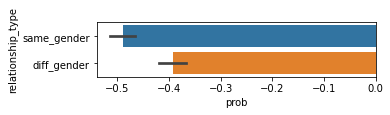

prob_stat                     prob
mean_same_gender_prob    -0.489537
mean_diff_gender_prob    -0.392944
mean_diff                -0.096593
test_stat               -27.064459
p                              0.0
dtype: object

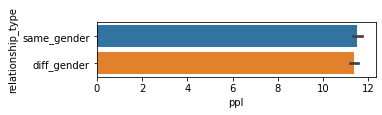

prob_stat                      ppl
mean_same_gender_prob    11.522122
mean_diff_gender_prob    11.364026
mean_diff                 0.158096
test_stat                 6.432136
p                              0.0
dtype: object

In [3]:
prob_stats = ['prob', 'ppl']
align_vars = ['lang', 'subject_word', 'subject_gender']
for prob_stat_i in prob_stats:
    plt.figure(figsize=(5, 1))
    sns.barplot(data=relationship_sent_data, y='relationship_type', x=prob_stat_i)
    plt.show()
    ## significance testing
    compare_stats_i = compare_same_diff_gender_prob_data(relationship_sent_data, prob_stat=prob_stat_i, align_vars=align_vars)
    display(compare_stats_i)
#     print(f'stat = {prob_stat_i}; mean diff = {mean_diff:.3f} (test stat = {test_stat:.3f}; p = {p_val:.3E})')

Great! The differences are significant. Same-gender relationships are overall less likely.

testing prob stat = prob


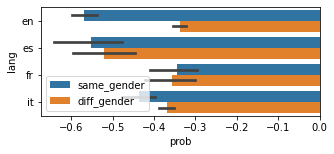

,prob_stat,mean_same_gender_prob,mean_diff_gender_prob,mean_diff,test_stat,p,lang
0,prob,-0.568416,-0.338088,-0.230328,-49.021291,0.0,en
1,prob,-0.552241,-0.520211,-0.03203,-3.518479,0.000435,es
2,prob,-0.344729,-0.355894,0.011165,1.300124,0.193578,fr
3,prob,-0.436295,-0.368817,-0.067478,-14.175395,0.0,it


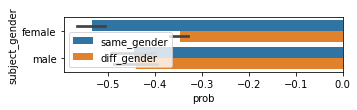

,prob_stat,mean_same_gender_prob,mean_diff_gender_prob,mean_diff,test_stat,p,subject_gender
0,prob,-0.534714,-0.346311,-0.188403,-43.565961,0.0,female
1,prob,-0.44436,-0.439577,-0.004783,-0.849106,0.395828,male


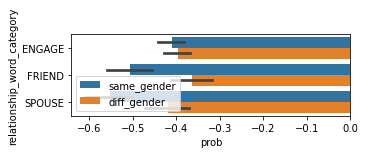

,prob_stat,mean_same_gender_prob,mean_diff_gender_prob,mean_diff,test_stat,p,relationship_word_category
0,prob,-0.409101,-0.395246,-0.013855,-1.836794,0.066281,ENGAGE
1,prob,-0.505824,-0.363624,-0.1422,-11.648142,0.0,FRIEND
2,prob,-0.553686,-0.419963,-0.133724,-13.040235,0.0,SPOUSE


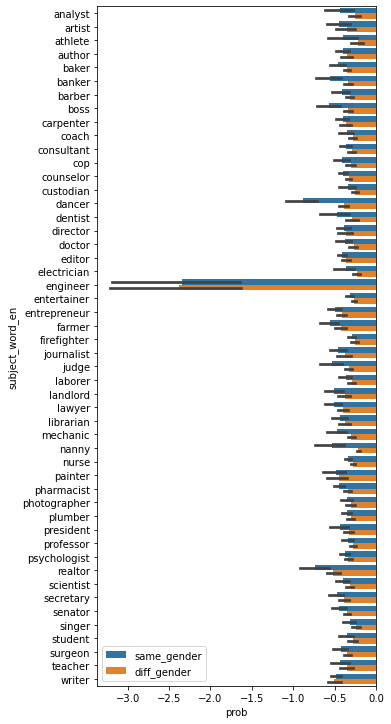

,prob_stat,mean_same_gender_prob,mean_diff_gender_prob,mean_diff,test_stat,p,subject_word_en
0,prob,-0.431104,-0.255538,-0.175566,-6.971339,0.0,analyst
1,prob,-0.446142,-0.351427,-0.094714,-3.921382,0.000102,artist
2,prob,-0.402565,-0.223321,-0.179244,-6.986293,0.0,athlete
3,prob,-0.401683,-0.356574,-0.045108,-3.626186,0.000296,author
4,prob,-0.455806,-0.348976,-0.10683,-8.637153,0.0,baker
5,prob,-0.561991,-0.339414,-0.222577,-11.009386,0.0,banker
6,prob,-0.414942,-0.317613,-0.097329,-6.683365,0.0,barber
7,prob,-0.565085,-0.335839,-0.229246,-12.603905,0.0,boss
8,prob,-0.400456,-0.364097,-0.036359,-2.795708,0.005252,carpenter
9,prob,-0.35502,-0.281707,-0.073313,-6.066422,0.0,coach


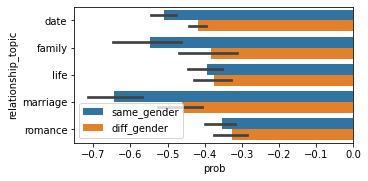

,prob_stat,mean_same_gender_prob,mean_diff_gender_prob,mean_diff,test_stat,p,relationship_topic
0,prob,-0.510061,-0.41826,-0.091801,-9.779938,0.0,date
1,prob,-0.54724,-0.384214,-0.163025,-11.258594,0.0,family
2,prob,-0.393499,-0.375276,-0.018224,-1.324149,0.185571,life
3,prob,-0.643096,-0.460508,-0.182588,-11.107136,0.0,marriage
4,prob,-0.35379,-0.326465,-0.027326,-2.395893,0.01665,romance


testing prob stat = ppl


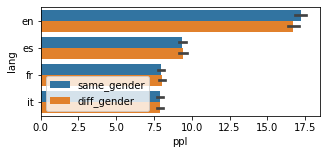

,prob_stat,mean_same_gender_prob,mean_diff_gender_prob,mean_diff,test_stat,p,lang
0,ppl,17.206745,16.723507,0.483238,7.846204,0.0,en
1,ppl,9.376126,9.407543,-0.031417,-0.940302,0.347077,es
2,ppl,7.97865,8.009232,-0.030582,-1.048037,0.294638,fr
3,ppl,7.918068,7.885791,0.032278,1.00389,0.315454,it


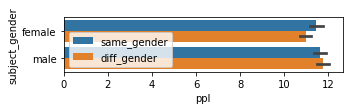

,prob_stat,mean_same_gender_prob,mean_diff_gender_prob,mean_diff,test_stat,p,subject_gender
0,ppl,11.437216,10.979176,0.45804,13.368026,0.0,female
1,ppl,11.607028,11.748876,-0.141848,-4.033127,0.000055,male


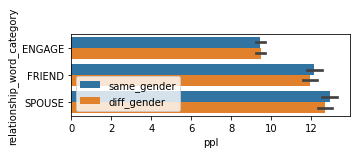

,prob_stat,mean_same_gender_prob,mean_diff_gender_prob,mean_diff,test_stat,p,relationship_word_category
0,ppl,9.461785,9.469024,-0.007239,-0.164007,0.86973,ENGAGE
1,ppl,12.156596,11.94311,0.213486,2.762295,0.005754,FRIEND
2,ppl,12.947984,12.679943,0.26804,3.526252,0.000424,SPOUSE


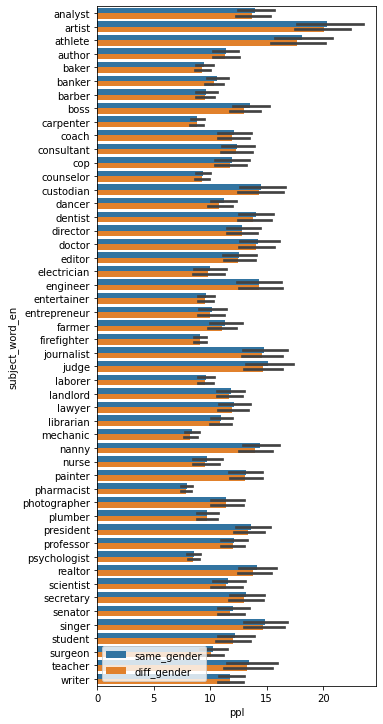

,prob_stat,mean_same_gender_prob,mean_diff_gender_prob,mean_diff,test_stat,p,subject_word_en
0,ppl,13.97947,13.706556,0.272914,0.930568,0.352577,analyst
1,ppl,20.361605,20.057284,0.304321,0.591011,0.55481,artist
2,ppl,18.160139,17.675603,0.484536,1.052381,0.293191,athlete
3,ppl,11.399722,11.31841,0.081312,0.600385,0.548325,author
4,ppl,9.431391,9.28764,0.143751,1.528703,0.126514,baker
5,ppl,10.609807,10.304998,0.30481,2.540143,0.011192,banker
6,ppl,9.642317,9.517243,0.125074,1.145759,0.252098,barber
7,ppl,13.504541,12.991017,0.513524,2.436244,0.014969,boss
8,ppl,8.848136,8.819966,0.02817,0.337422,0.735851,carpenter
9,ppl,12.111979,11.969934,0.142045,0.789877,0.429738,coach


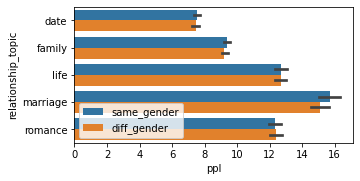

,prob_stat,mean_same_gender_prob,mean_diff_gender_prob,mean_diff,test_stat,p,relationship_topic
0,ppl,7.523505,7.446509,0.076996,3.002852,0.0027,date
1,ppl,9.362717,9.217932,0.144785,3.610143,0.000312,family
2,ppl,12.684616,12.679077,0.005539,0.091318,0.927247,life
3,ppl,15.69328,15.103954,0.589326,5.884493,0.0,marriage
4,ppl,12.346491,12.372658,-0.026168,-0.406905,0.684111,romance


In [4]:
## breakdown by language, gender, target, relationship, source occupation
relationship_vars = ['lang', 'subject_gender', 'relationship_word_category', 'subject_word_en', 'relationship_topic']
width = 5
height = 0.5
align_vars = ['lang', 'subject_word', 'subject_gender']
prob_stats = ['prob', 'ppl']
for prob_stat in prob_stats:
    print(f'testing prob stat = {prob_stat}')
    for var_i in relationship_vars:
        vals_i = relationship_sent_data.loc[:, var_i].nunique()
        height_i = vals_i*height
        if(vals_i > 10):
            height_i = height_i * 0.5
        plt.figure(figsize=(width, height_i))
        val_order_i = list(sorted(relationship_sent_data.loc[:, var_i].unique()))
        sns.barplot(data=relationship_sent_data, x=prob_stat, y=var_i, order=val_order_i, hue='relationship_type')
        plt.legend(loc='lower left')
        plt.show()
        # compare within-group
        compare_stats_i = []
        for val_j, data_j in relationship_sent_data.groupby(var_i):
            compare_stats_j = compare_same_diff_gender_prob_data(data_j, prob_stat=prob_stat, align_vars=align_vars)
            compare_stats_j.loc[var_i] = val_j
            compare_stats_i.append(compare_stats_j)
        compare_stats_i = pd.concat(compare_stats_i, axis=1).transpose()
        display(compare_stats_i)

OK! We can see pretty clearly that same-gender relationships are dispreferred pretty much across the board.

Trends in PPL:
- lang:
    - `en`: `same` > `diff`
- gender:
    - `female`: `same` > `diff`
    - `male`: `diff` > `same` (translation errors? data imbalance?)
- target:
    - `FRIEND`: `same` > `diff`
    - `SPOUSE`: `same` > `diff`
- occupation:
    - `banker`: `same` > `diff`
    - `boss`: `same` > `diff`
    - `dancer`: `same` > `diff`
- topic:
    - `date`: `same` > `diff`
    - `family`: `same` > `diff`
    - `marriage`: `same` >>> `diff`

Plot everything!

/local2/ianbstew/multilingual_same_gender_bias/data_helpers.py:341: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_i.set_xticklabels(ax_i.get_xticklabels(), rotation=45)
/local2/ianbstew/multilingual_same_gender_bias/data_helpers.py:341: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_i.set_xticklabels(ax_i.get_xticklabels(), rotation=45)
/local2/ianbstew/multilingual_same_gender_bias/data_helpers.py:341: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_i.set_xticklabels(ax_i.get_xticklabels(), rotation=45)
/local2/ianbstew/multilingual_same_gender_bias/data_helpers.py:341: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_i.set_xticklabels(ax_i.get_xticklabels(), rotation=45)


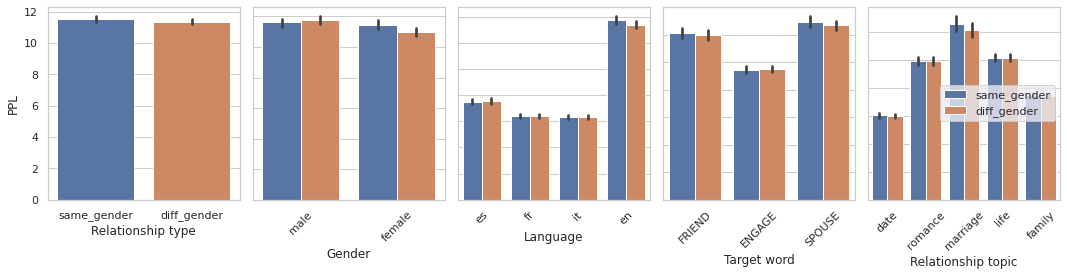

In [8]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import plot_scores_by_attr
plot_scores_by_attr(relationship_sent_data.rename(columns={'ppl':'PPL'}), 
                    score_var='PPL', type_var_name='Relationship type')

### Compare probability for correct/wrong translations

Having previously computed accuracy for translations, let's try to predict that accuracy using the probability scores computed here.

In [9]:
## load translation data
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import load_clean_translation_data
same_gender_translation_file = 'data/multilingual_occupation_relationship=samegender_model=googletranslate_translations.gz'
diff_gender_translation_file = 'data/multilingual_occupation_relationship=diffgender_model=googletranslate_translations.gz'
same_gender_translation_data = load_clean_translation_data(same_gender_translation_file)
diff_gender_translation_data = load_clean_translation_data(diff_gender_translation_file)
combined_translation_data = pd.concat([
    same_gender_translation_data.assign(**{'relationship_type' : 'same_gender'}),
    diff_gender_translation_data.assign(**{'relationship_type' : 'diff_gender'}),
])

bad text the ingeniero lived with his fianc2e.
bad text the farmer kissed his boy.
bad text the peasant lived with his boy.
bad text the farmer and his boy have a son.
bad text the banker kissed his bride.
bad text the carpenter kissed his bride.
bad text the farmer kissed his bride.
bad text the engineer lived with his fianc2ee.


In [10]:
relationship_sent_data[relationship_sent_data.loc[:, 'lang']=='en']

,Unnamed: 0,sent,lang,subject_word,relationship_word,subject_gender,relationship_topic,relationship_gender,relationship_type,subject_word_en,relationship_word_en,relationship_word_category,prob,ppl
2820,2820,the analyst met his boyfriend on a date.,en,analyst,boyfriend,male,date,male,same_gender,analyst,boyfriend,FRIEND,-0.205639,10.145233
2821,2821,the analyst met his fiancé on a date.,en,analyst,fiancé,male,date,male,same_gender,analyst,fiance,ENGAGE,-0.267182,8.478218
2822,2822,the analyst met his husband on a date.,en,analyst,husband,male,date,male,same_gender,analyst,husband,SPOUSE,-0.226326,10.099221
2823,2823,the artist met his boyfriend on a date.,en,artist,boyfriend,male,date,male,same_gender,artist,boyfriend,FRIEND,-0.335040,13.495045
2824,2824,the artist met his fiancé on a date.,en,artist,fiancé,male,date,male,same_gender,artist,fiance,ENGAGE,-0.252826,10.760614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,4315,the teacher and her fiancé have a child.,en,teacher,fiancé,female,family,male,diff_gender,teacher,fiance,ENGAGE,-0.603510,10.788191
8636,4316,the teacher and her husband have a child.,en,teacher,husband,female,family,male,diff_gender,teacher,husband,SPOUSE,-0.113159,13.291407
8637,4317,the writer and her boyfriend have a child.,en,writer,boyfriend,female,family,male,diff_gender,writer,boyfriend,FRIEND,-0.696811,13.213361
8638,4318,the writer and her fiancé have a child.,en,writer,fiancé,female,family,male,diff_gender,writer,fiance,ENGAGE,-2.220899,12.374187


In [11]:
## combine LM prob, translation acc data
merge_cols = ['sent']
translation_acc_cols = ['subject_gender_match']
combined_lang_score_data = pd.merge(relationship_sent_data, combined_translation_data.loc[:, merge_cols + translation_acc_cols],
                                    on=merge_cols, how='inner')
print(combined_lang_score_data.shape[0])
## also add EN LM probs
en_relationship_sent_data = relationship_sent_data[relationship_sent_data.loc[:, 'lang']=='en']
en_relationship_sent_data.rename(columns={'prob' : 'prob_en', 'ppl' : 'ppl_en'}, inplace=True)
en_prob_cols = ['prob_en', 'ppl_en']
en_merge_cols = ['subject_gender', 'subject_word_en', 'relationship_gender', 'relationship_word_category', 'relationship_topic']
combined_lang_score_data = pd.merge(combined_lang_score_data, 
                                    en_relationship_sent_data.loc[:, en_prob_cols + en_merge_cols],
                                    on=en_merge_cols, how='inner')
print(combined_lang_score_data.shape[0])
display(combined_lang_score_data.head())

5640
5640


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Unnamed: 0,sent,lang,subject_word,relationship_word,subject_gender,relationship_topic,relationship_gender,relationship_type,subject_word_en,relationship_word_en,relationship_word_category,prob,ppl,subject_gender_match,prob_en,ppl_en
0,0,el autor conoció a su novio en una cita.,es,autor,novio,male,date,male,same_gender,author,boyfriend,FRIEND,-0.949337,8.163404,0,-0.354644,12.611437
1,1080,l'auteur a rencontré son petit ami à un rendez...,fr,auteur,petit ami,male,date,male,same_gender,author,boyfriend,FRIEND,-0.272745,4.289619,0,-0.354644,12.611437
2,2100,l'autore ha incontrato il suo ragazzo ad un ap...,it,autore,ragazzo,male,date,male,same_gender,author,boyfriend,FRIEND,-0.101428,5.036685,0,-0.354644,12.611437
3,1,el autor conoció a su prometido en una cita.,es,autor,prometido,male,date,male,same_gender,author,fiance,ENGAGE,-0.702225,6.898103,0,-0.195139,9.906832
4,1081,l'auteur a rencontré son fiancé à un rendez-vo...,fr,auteur,fiancé,male,date,male,same_gender,author,fiance,ENGAGE,-0.234081,4.295297,0,-0.195139,9.906832


Are the sentences that have correct translations more likely to have a high LM score in the target language?

testing prob_var=ppl


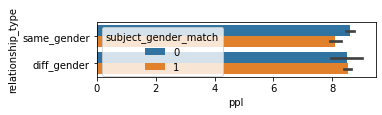

** relationship_type = diff_gender**
median diff = -0.348 (test stat = 102674.000, p=2.738E-01)
** relationship_type = same_gender**
median diff = -0.125 (test stat = 600271.500, p=4.082E-02)
testing prob_var=ppl_en


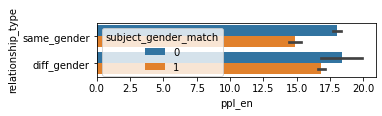

** relationship_type = diff_gender**
median diff = -0.871 (test stat = 91491.500, p=1.469E-02)
** relationship_type = same_gender**
median diff = -2.555 (test stat = 495129.500, p=2.094E-15)


In [12]:
## plot correct vs. incorrect (X) and prob score (Y)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
prob_vars = ['ppl', 'ppl_en']
for prob_var in prob_vars:
    print(f'testing prob_var={prob_var}')
    plt.figure(figsize=(5,1))
    sns.barplot(data=combined_lang_score_data, y='relationship_type', hue='subject_gender_match', x=prob_var)
    plt.show()
    for relationship_type_i, data_i in combined_lang_score_data.groupby('relationship_type'):
        print(f'** relationship_type = {relationship_type_i}**')
        correct_translation_score_data_i = data_i[data_i.loc[:, 'subject_gender_match']==1].loc[:, prob_var]
        incorrect_translation_score_data_i = data_i[data_i.loc[:, 'subject_gender_match']==0].loc[:, prob_var]
        median_diff = correct_translation_score_data_i.median() - incorrect_translation_score_data_i.median()
        test_stat, p_val = mannwhitneyu(correct_translation_score_data_i, incorrect_translation_score_data_i)
        print(f'median diff = {median_diff:.3f} (test stat = {test_stat:.3f}, p={p_val:.3E})')

The difference in PPL is especially high for the English sentence! This suggests that the problem is likely on both sides but especially on the target (English LM) side.

testing prob_var=ppl


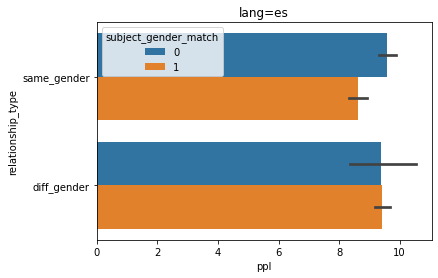

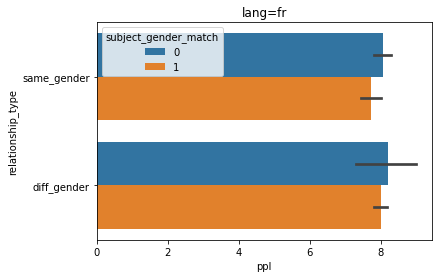

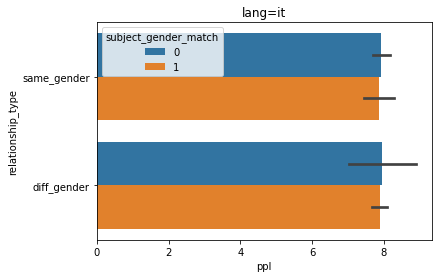

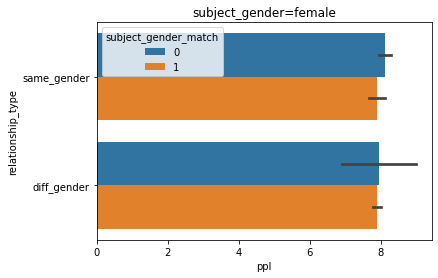

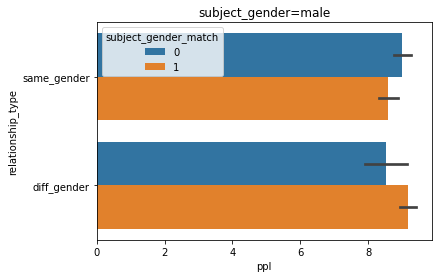

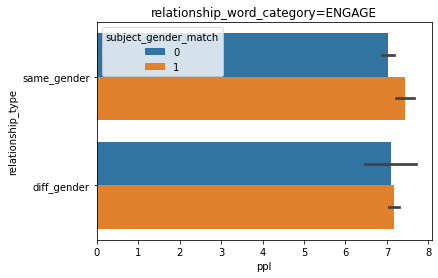

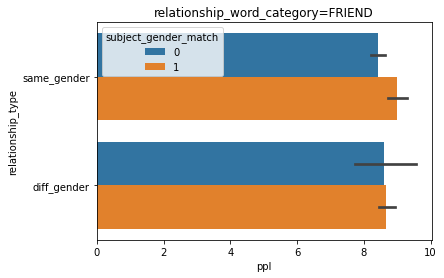

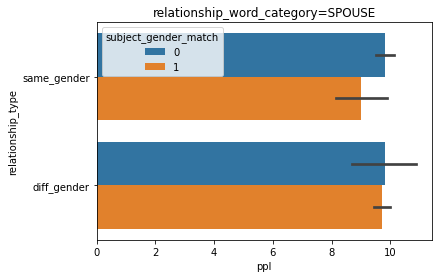

testing prob_var=ppl_en


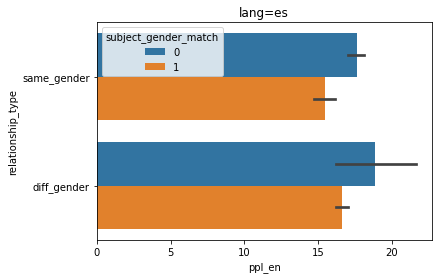

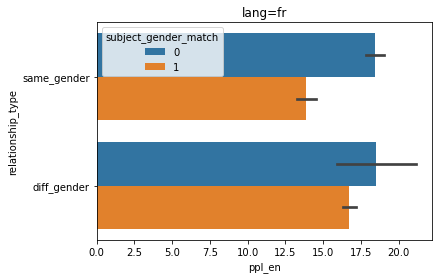

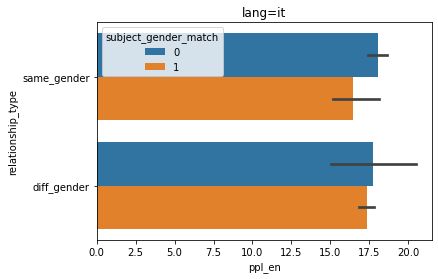

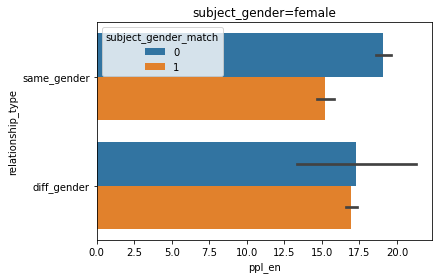

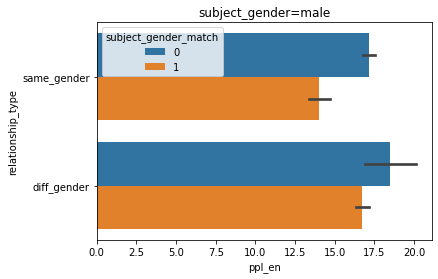

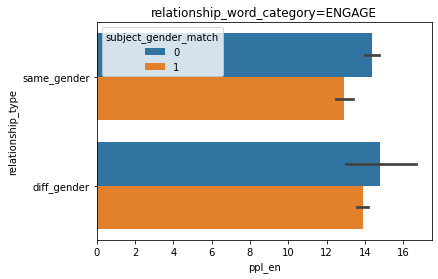

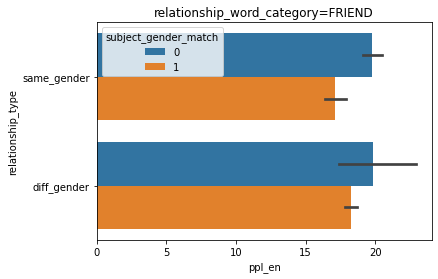

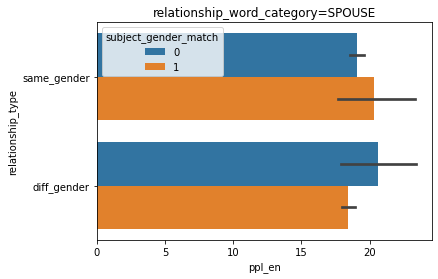

In [22]:
## per-subgroup
for prob_var in prob_vars:
    print(f'testing prob_var={prob_var}')
    subgroup_vars = ['lang', 'subject_gender', 'relationship_word_category']
    for subgroup_var_i in subgroup_vars:
        for subgroup_val_j, data_j in combined_lang_score_data.groupby(subgroup_var_i):
            sns.barplot(data=data_j, y='relationship_type', hue='subject_gender_match', x=prob_var)
            plt.title(f'{subgroup_var_i}={subgroup_val_j}')
            plt.show()

In general, the `same_gender` relationships have higher perplexity for incorrect translations. It is more obvious in certain contexts:

- `lang`: `es`, `fr`
- `subject_gender`: `female`

The `same_gender` relationships have **lower** perplexity for correct translations in some cases!
- `relationship_type`: `ENGAGE`, `FRIEND`

This suggests that the LM is more confused by different-gender translations for `ENGAGE` and `FRIEND`, which could be driven ambiguity around e.g. `girlfriend` (either romantic or platonic).

The translation model tends to get high-perplexity sentences wrong when translating same-gender relationship sentences.

So the solution must be to retrain the model (particularly the English LM) with high-perplexity sentences to force it to learn about same-gender relationships more readily.